<a href="https://colab.research.google.com/github/nikakoga/Bioinformatic/blob/main/training_PCSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np

all_data = pd.read_csv("/content/drive/MyDrive/IBD/PCSS.zip (Unzipped Files)/genes_response_dataset.csv")
all_data = all_data.replace('N', np.NaN)

datasets = [
    "GSE206285",
    "GSE207022",
    "GSE112366",
]
ustekinumab = all_data[all_data["dataset"].isin(datasets)]
ustekinumab = ustekinumab[ustekinumab['response']!="CO"]
ustekinumab = ustekinumab.dropna(axis=1, how='all')

<ipython-input-6-48e04890d6d6>:4: DtypeWarning: Columns (5,12,13,17,20,21,22,24,32,48,60,80,82,83,86,87,88,89,90,91,102,111,112,113,117,131,139,140,142,147,151,152,153,154,159,160,164,176,177,180,189,193,194,196,198,205,207,209,216,231,233,240,243,245,248,262,283,286,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,362,363,367,372,378,379,391,392,393,400,405,406,407,417,418,419,420,421,424,433,434,435,436,437,469,482,484,488,490,492,493,494,501,510,518,520,527,561,562,563,567,575,593,605,606,612,615,616,617,619,621,623,636,637,638,641,645,661,664,665,671,672,678,695,698,706,707,709,711,714,715,716,720,721,732,733,734,735,736,744,757,760,763,766,772,778,781,784,805,806,811,812,813,814,816,822,829,835,836,841,849,855,857,859,861,862,886,892,899,901,904,905,916,922,927,929,933,948,952,954,955,958,963,974,975,976,978,979,982,984,985,993,994,1001,1002,1006,1009,1011,1012,1013,1017,1020,1022,1033,1046,1047,1048,1049,1050,1051

In [38]:
# Grupowanie danych po 'dataset' i liczenie warto≈õci 'response'
response_counts = ustekinumab.groupby('dataset')['response'].value_counts().unstack(fill_value=0)

# Wy≈õwietlenie wynik√≥w
print(response_counts)


response    No  Yes
dataset            
GSE112366  179  183
GSE206285  455   95
GSE207022  113   12


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


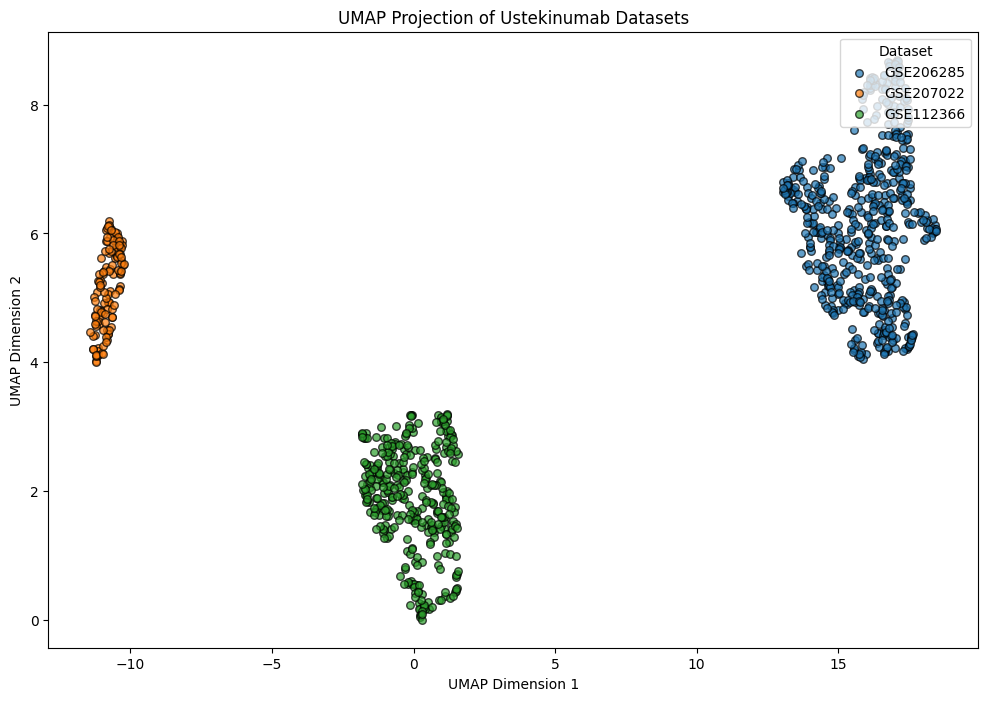

In [59]:
# Wybierz tylko kolumny numeryczne
numerical_data = ustekinumab.select_dtypes(include=[np.number]).dropna(axis=0, how='any')

# Dopasowanie etykiet do zredukowanego zbioru danych
ustekinumab = ustekinumab.loc[numerical_data.index]
dataset_labels = ustekinumab['dataset']

# Standaryzacja danych
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Redukcja wymiarowo≈õci za pomocƒÖ UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(numerical_data_scaled)

# Kolory dla poszczeg√≥lnych dataset√≥w
dataset_colors = {
    "GSE206285": 'tab:blue',
    "GSE207022": 'tab:orange',
    "GSE112366": 'tab:green'
}

# Wizualizacja UMAP
plt.figure(figsize=(12, 8))
for dataset, color in dataset_colors.items():
    subset = dataset_labels == dataset
    plt.scatter(
        embedding[subset, 0],
        embedding[subset, 1],
        label=dataset,
        color=color,
        s=30,
        alpha=0.7,
        edgecolor='k'
    )

plt.title('UMAP Projection of Ustekinumab Datasets')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Dataset', loc='upper right')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


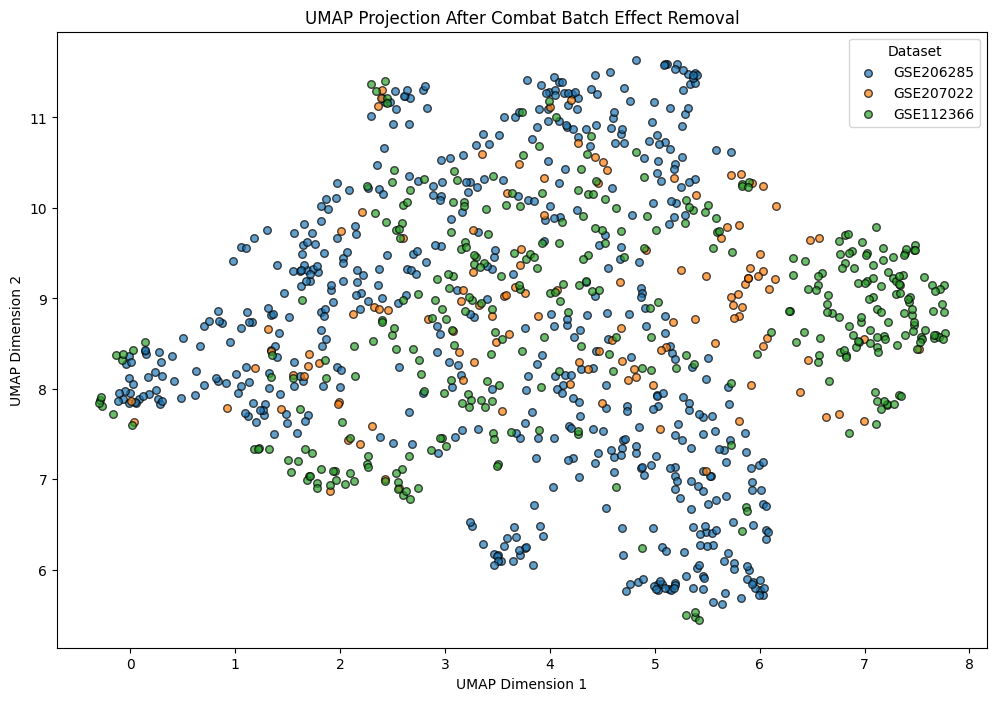

In [60]:
# Przygotowanie metadanych
batch_labels = ustekinumab['dataset']

# Standaryzacja danych
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Konwersja do AnnData (struktura danych u≈ºywana w scanpy)
adata = sc.AnnData(numerical_data_scaled)
adata.obs['batch'] = batch_labels.values

# Usuniƒôcie efektu partii za pomocƒÖ Combat
sc.pp.combat(adata, key='batch')

# Redukcja wymiarowo≈õci za pomocƒÖ UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(adata.X)

# Kolory dla poszczeg√≥lnych dataset√≥w
dataset_colors = {
    "GSE206285": 'tab:blue',
    "GSE207022": 'tab:orange',
    "GSE112366": 'tab:green'
}

# Wizualizacja UMAP
plt.figure(figsize=(12, 8))
for dataset, color in dataset_colors.items():
    subset = batch_labels == dataset
    plt.scatter(
        embedding[subset, 0],
        embedding[subset, 1],
        label=dataset,
        color=color,
        s=30,
        alpha=0.7,
        edgecolor='k'
    )

plt.title('UMAP Projection After Combat Batch Effect Removal')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Dataset', loc='upper right')
plt.show()

üîÑ Verifying data consistency...
‚úÖ Number of samples: 1037
‚úÖ Unique batch labels: ['GSE206285' 'GSE207022' 'GSE112366']


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs val

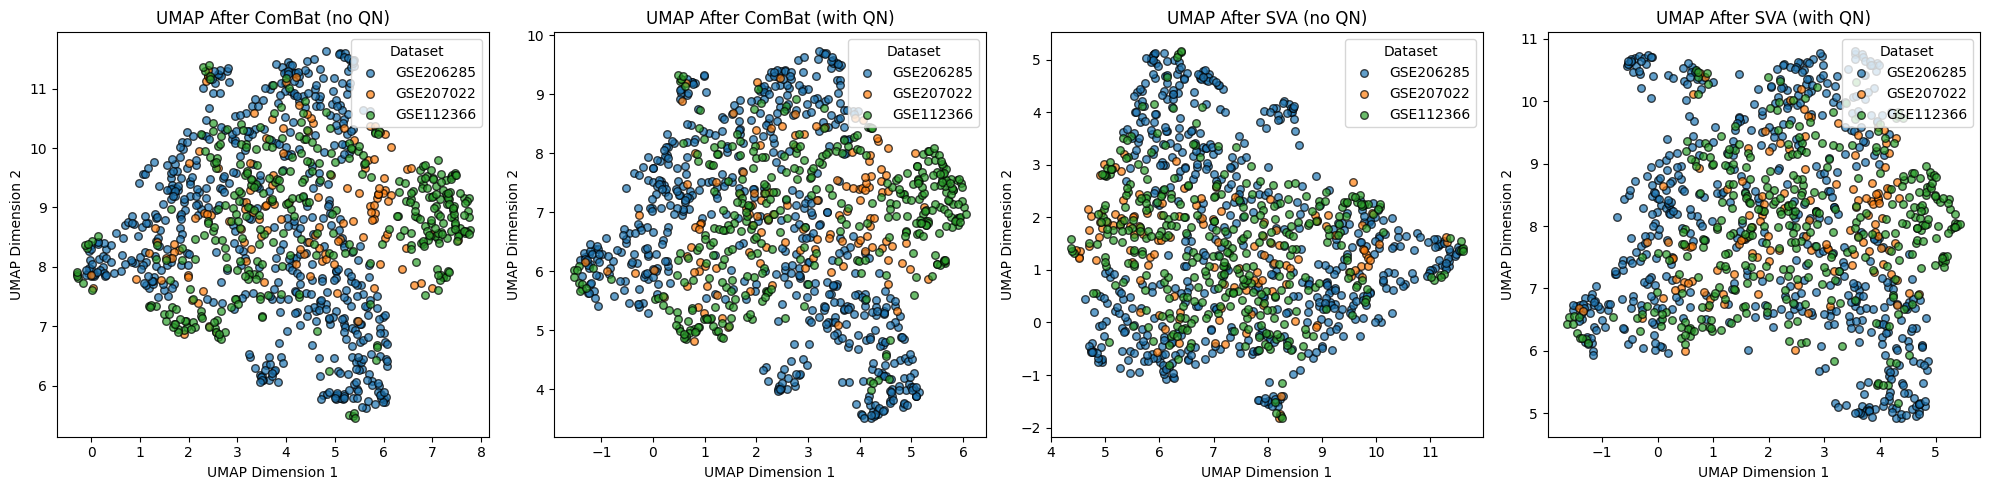

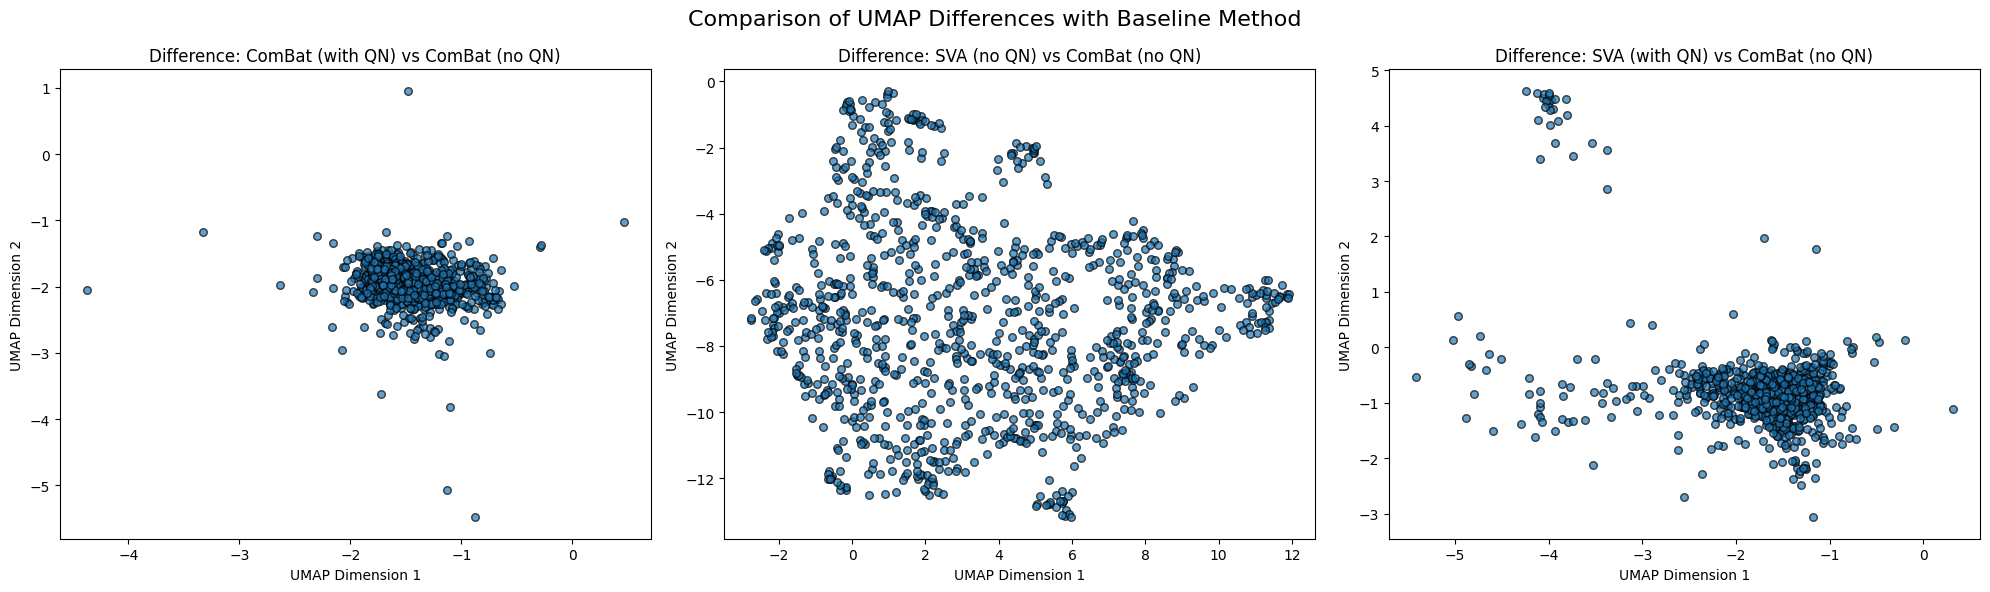


üìä Summary of Batch Effect Removal Methods:
                  Silhouette Score  Batch Variance
SVA (no QN)              -0.034823    4.216681e-31
SVA (with QN)            -0.016989    3.754239e-31
ComBat (with QN)         -0.003379    4.367439e-07
ComBat (no QN)           -0.001815    1.542802e-07


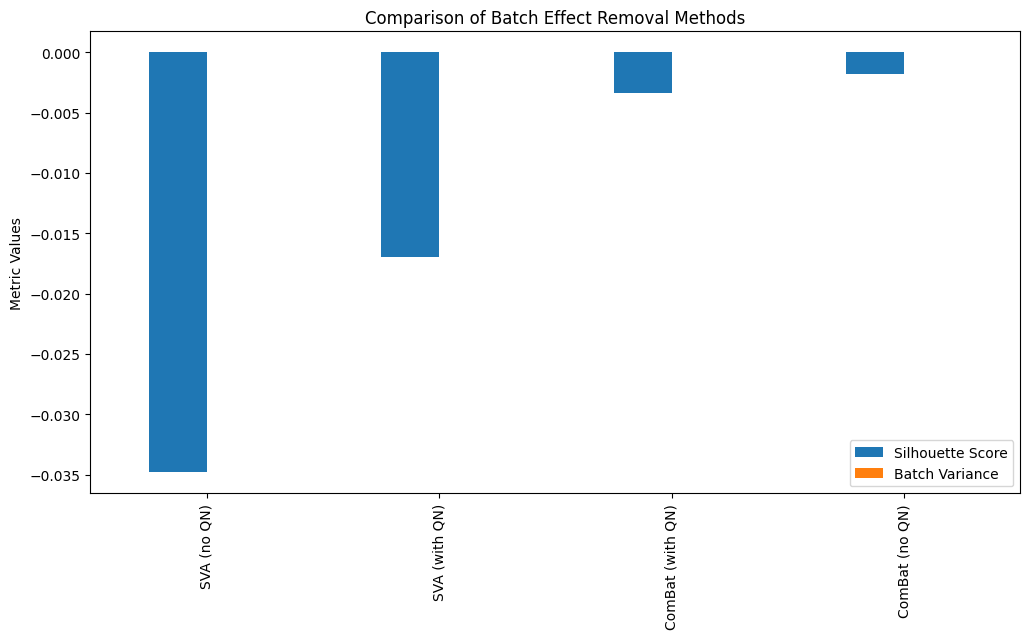

‚úÖ Pipeline successfully completed.


In [22]:
import scanpy as sc
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import silhouette_score


# === Batch Effect Removal Pipeline and UMAP Visualization ===
def batch_effect_pipeline(data, batch_labels):
    """
    Pipeline for batch effect removal (ComBat, SVA) and UMAP visualization.

    Parameters:
    - data: Gene expression data matrix
    - batch_labels: Batch labels for samples

    Returns:
    - embeddings: Dictionary with UMAP embeddings for each method
    - results: Dictionary with batch effect removal evaluation metrics
    """
    print("üîÑ Verifying data consistency...")
    assert len(data) == len(batch_labels), "Data and batch labels must have the same number of samples!"
    assert batch_labels.isnull().sum() == 0, "Batch labels cannot contain null values!"
    print(f"‚úÖ Number of samples: {len(data)}")
    print(f"‚úÖ Unique batch labels: {batch_labels.unique()}")

    batch_labels = batch_labels.astype('category')

    # Data standardization
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Quantile Normalization
    transformer = QuantileTransformer(output_distribution='normal', random_state=42, copy=True)
    data_qn = transformer.fit_transform(data_scaled)

    methods = {
        'ComBat (no QN)': data_scaled,
        'ComBat (with QN)': data_qn,
        'SVA (no QN)': data_scaled,
        'SVA (with QN)': data_qn
    }

    embeddings = {}
    results = {}

    fig, axes = plt.subplots(1, len(methods), figsize=(20, 5))
    dataset_colors = {
        "GSE206285": 'tab:blue',
        "GSE207022": 'tab:orange',
        "GSE112366": 'tab:green'
    }

    for ax, (method, dataset) in zip(axes, methods.items()):
        adata = sc.AnnData(dataset)
        adata.obs['batch'] = batch_labels.values
        adata.obs['batch'] = adata.obs['batch'].astype('category')
        adata.obs['method'] = method

        if 'ComBat' in method:
            sc.pp.combat(adata, key='batch')
        elif 'SVA' in method:
            sc.pp.regress_out(adata, ['batch'])

        # UMAP Dimensionality Reduction
        reducer = umap.UMAP(random_state=42)
        embedding = reducer.fit_transform(adata.X)
        embeddings[method] = embedding

        # Evaluation Metrics
        silhouette = silhouette_score(adata.X, adata.obs['batch'])
        batch_variance = np.var(np.mean(adata.X, axis=0))

        results[method] = {
            'Silhouette Score': silhouette,
            'Batch Variance': batch_variance
        }

        # UMAP Visualization on Subplot
        for dataset_label, color in dataset_colors.items():
            subset = adata.obs['batch'] == dataset_label
            ax.scatter(
                embedding[subset, 0],
                embedding[subset, 1],
                label=dataset_label,
                color=color,
                s=30,
                alpha=0.7,
                edgecolor='k'
            )

        ax.set_title(f'UMAP After {method}')
        ax.set_xlabel('UMAP Dimension 1')
        ax.set_ylabel('UMAP Dimension 2')
        ax.legend(title='Dataset', loc='upper right')

    plt.tight_layout()
    plt.show()

    return embeddings, results


# === UMAP Comparison Function ===
def compare_umap_embeddings(embeddings):
    """
    Function to compare differences between UMAP embeddings.
    """
    baseline_method = list(embeddings.keys())[0]
    baseline_embedding = embeddings[baseline_method]

    fig, axes = plt.subplots(1, len(embeddings) - 1, figsize=(20, 6))
    fig.suptitle('Comparison of UMAP Differences with Baseline Method', fontsize=16)

    for ax, (method, embedding) in zip(axes, list(embeddings.items())[1:]):
        difference = embedding - baseline_embedding
        ax.scatter(difference[:, 0], difference[:, 1], s=30, alpha=0.7, edgecolor='k')
        ax.set_title(f'Difference: {method} vs {baseline_method}')
        ax.set_xlabel('UMAP Dimension 1')
        ax.set_ylabel('UMAP Dimension 2')

    plt.tight_layout()
    plt.show()


# === Results Summary Function ===
def display_results_summary(results):
    """
    Displays a summary of results for batch effect removal methods.
    """
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values(by='Silhouette Score')

    print("\nüìä Summary of Batch Effect Removal Methods:")
    print(results_df)
    results_df.plot(kind='bar', figsize=(12, 6), title='Comparison of Batch Effect Removal Methods')
    plt.ylabel('Metric Values')
    plt.show()


# === Example Usage ===
# Data validation and cleaning
numerical_data = numerical_data.loc[ustekinumab['dataset'].index]
valid_idx = ustekinumab['dataset'].notnull()
numerical_data = numerical_data[valid_idx]
dataset_labels = ustekinumab['dataset'][valid_idx]

# Data processing and UMAP generation
embeddings, results = batch_effect_pipeline(numerical_data, dataset_labels)

# Comparison of differences relative to the first method
compare_umap_embeddings(embeddings)

# Results summary
display_results_summary(results)

print("‚úÖ Pipeline successfully completed.")


‚úÖ Dane zosta≈Çy przygotowane.
üéØ Unikalne warto≈õci w y: [0 1]

üöÄ Walidacja krzy≈ºowa z u≈ºyciem GroupKFold na pe≈Çnym zbiorze danych...
üîÑ **Fold 1**
Train Groups: ['GSE207022' 'GSE112366']
Validation Groups: ['GSE206285']
----------------------------------------
üîÑ **Fold 2**
Train Groups: ['GSE206285' 'GSE207022']
Validation Groups: ['GSE112366']
----------------------------------------
üîÑ **Fold 3**
Train Groups: ['GSE206285' 'GSE112366']
Validation Groups: ['GSE207022']
----------------------------------------
‚úÖ Sprawd≈∫ powy≈ºszy podzia≈Ç grup i wci≈õnij Enter, aby kontynuowaƒá...
üîÑ **Fold 1 - Random Forest**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


üîÑ **Fold 2 - Random Forest**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


üîÑ **Fold 3 - Random Forest**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


üîÑ **Fold 1 - Gradient Boosting**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


üîÑ **Fold 2 - Gradient Boosting**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


üîÑ **Fold 3 - Gradient Boosting**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


üîÑ **Fold 1 - LightGBM**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define 

[LightGBM] [Info] Number of positive: 292, number of negative: 292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 584, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


üîÑ **Fold 2 - LightGBM**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define 

[LightGBM] [Info] Number of positive: 568, number of negative: 568
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 1136, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


üîÑ **Fold 3 - LightGBM**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define 

[LightGBM] [Info] Number of positive: 634, number of negative: 634
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 1268, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


üîÑ **Fold 1 - XGBoost**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define t

üîÑ **Fold 2 - XGBoost**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define t

üîÑ **Fold 3 - XGBoost**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define t

üîÑ **Fold 1 - Logistic Regression**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 72.
The score on these train-test partitions for

üîÑ **Fold 2 - Logistic Regression**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 72.
The score on these train-test partitions for

üîÑ **Fold 3 - Logistic Regression**


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 72.
The score on these train-test partitions for

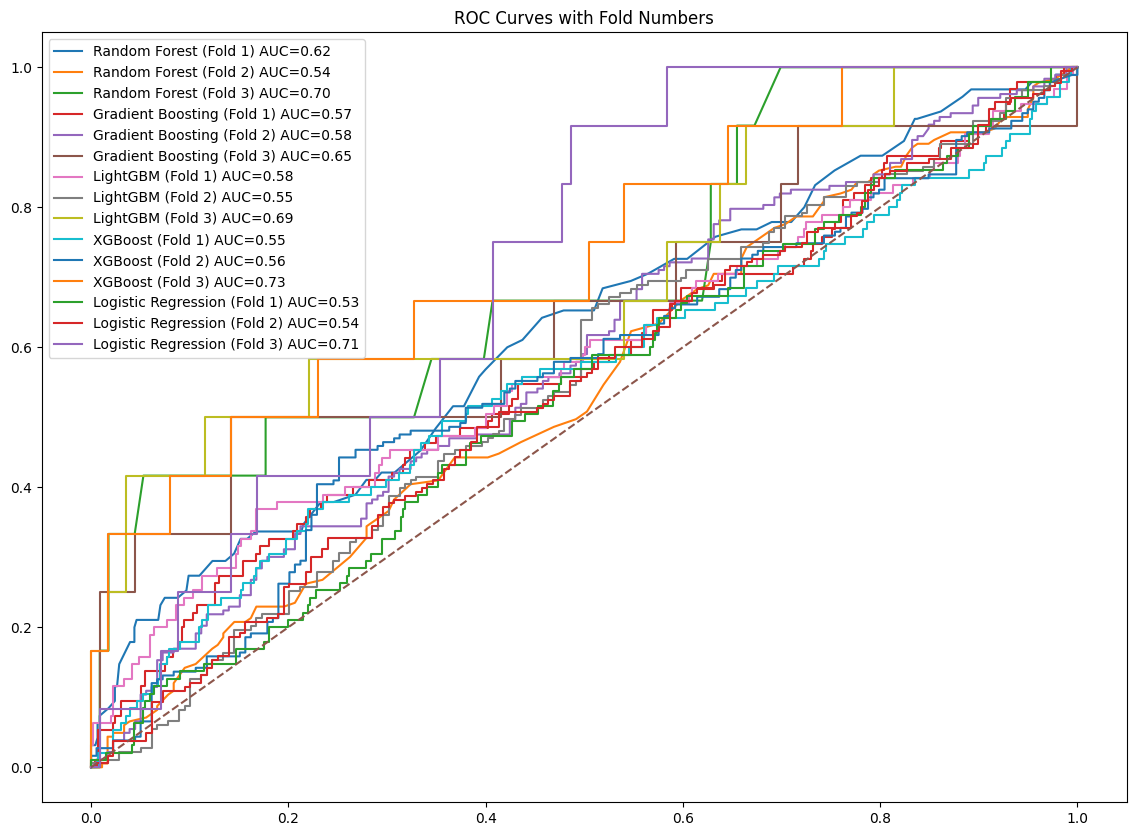

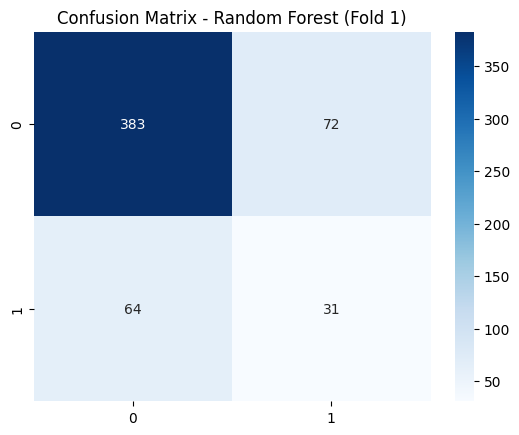

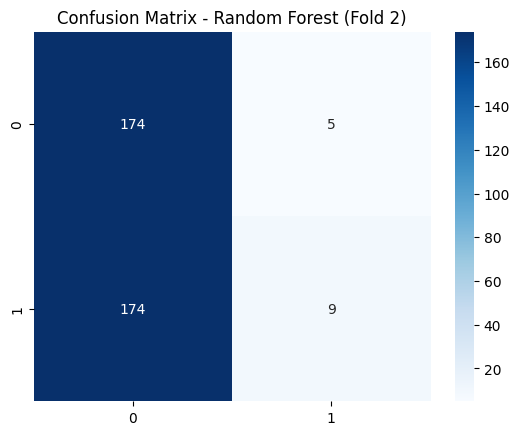

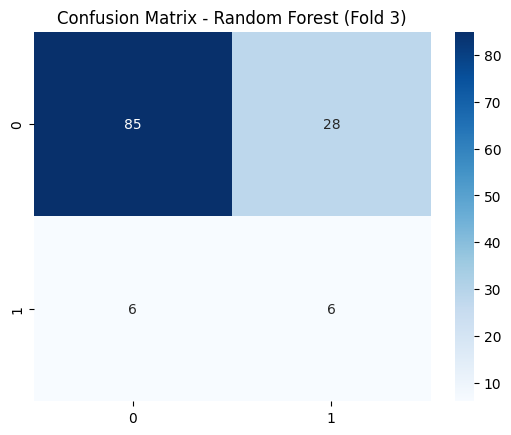

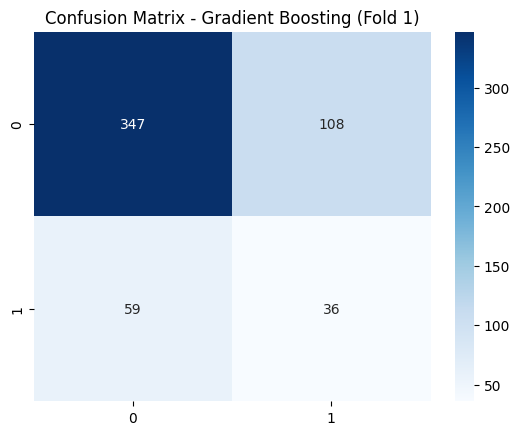

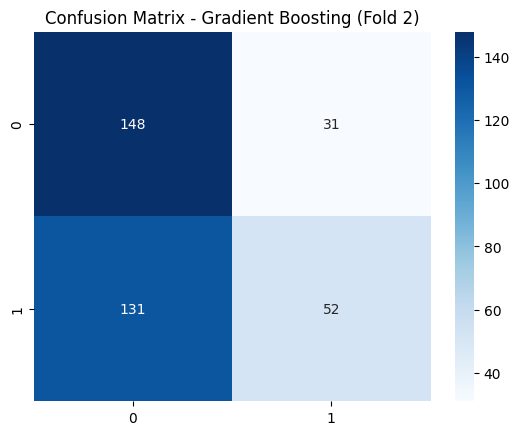

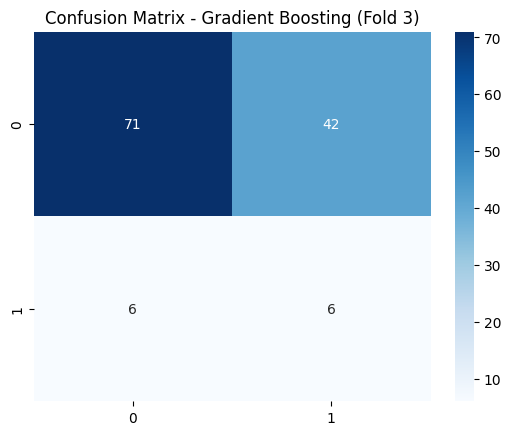

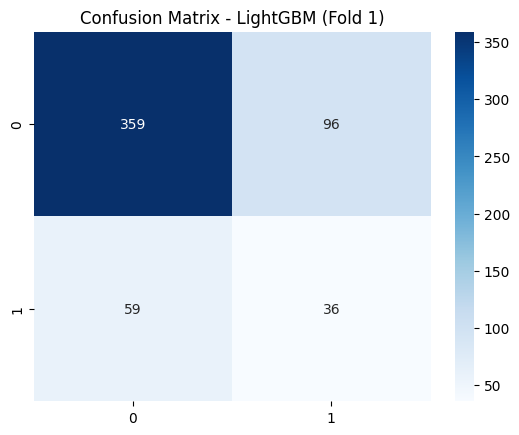

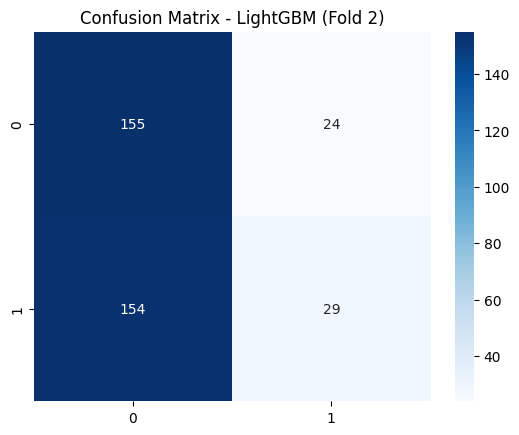

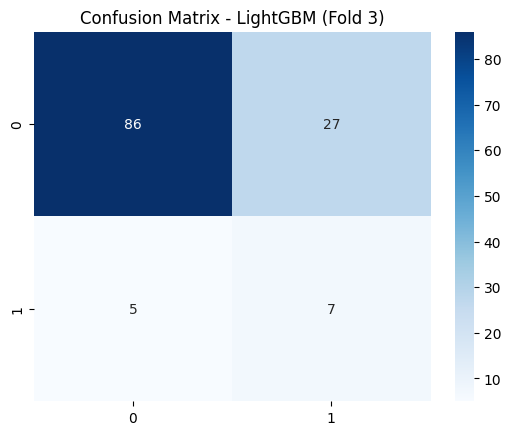

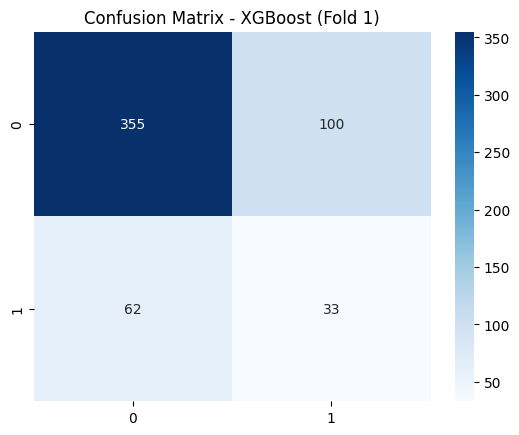

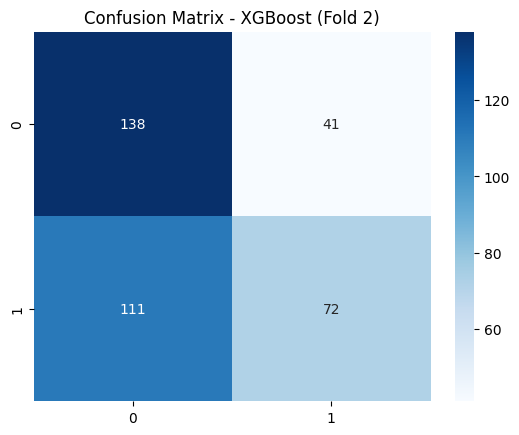

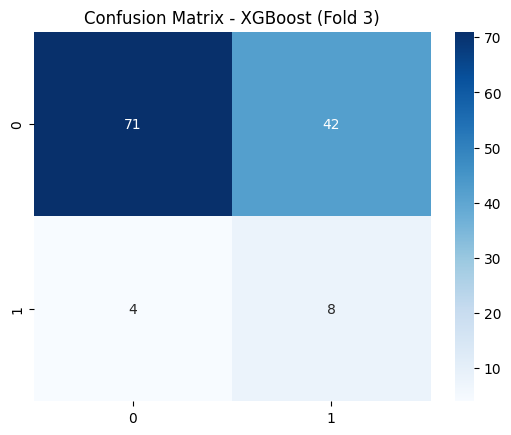

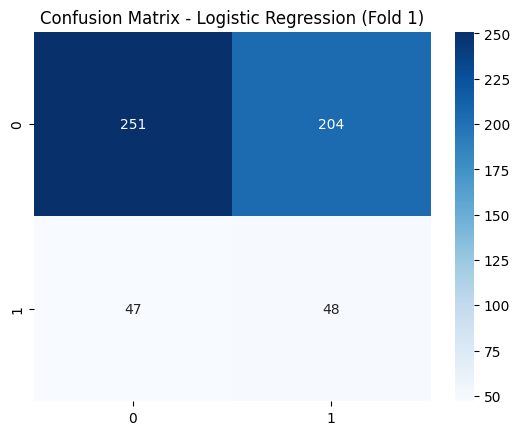

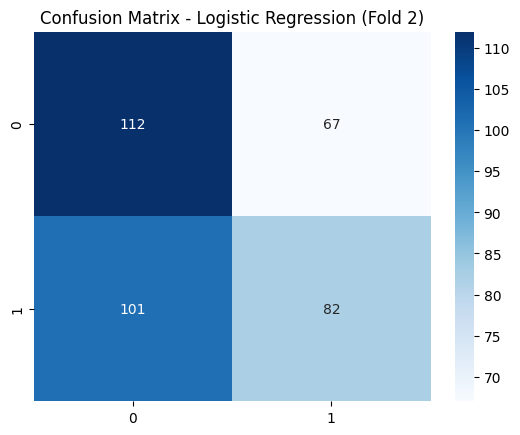

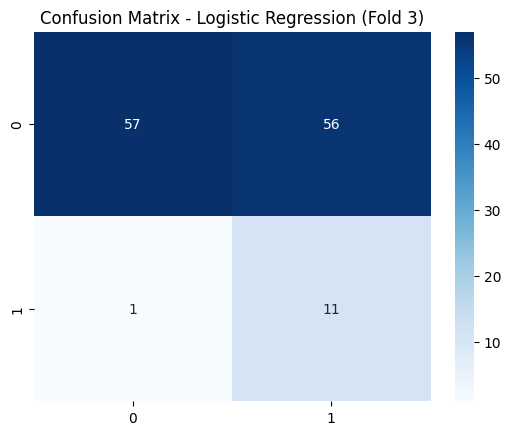

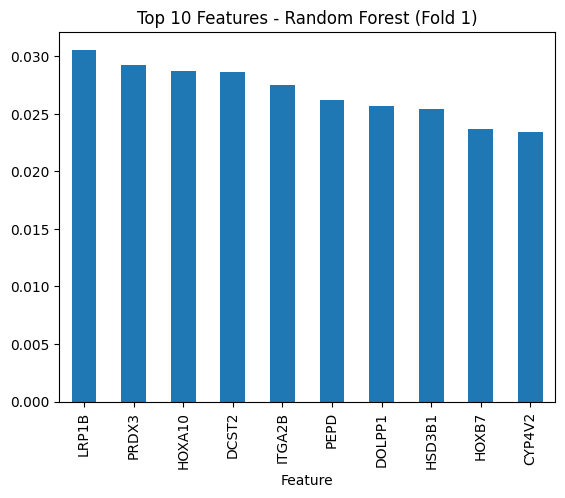

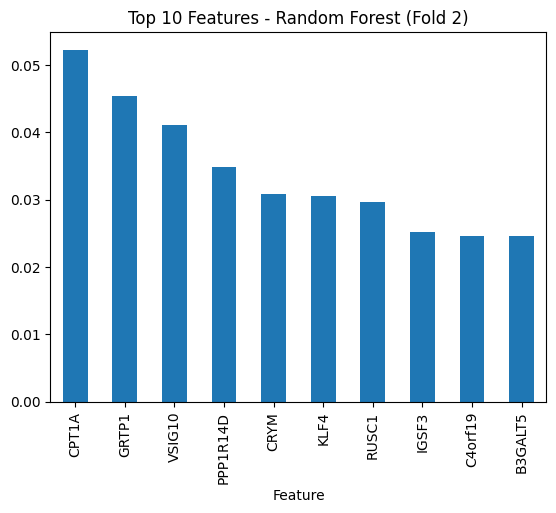

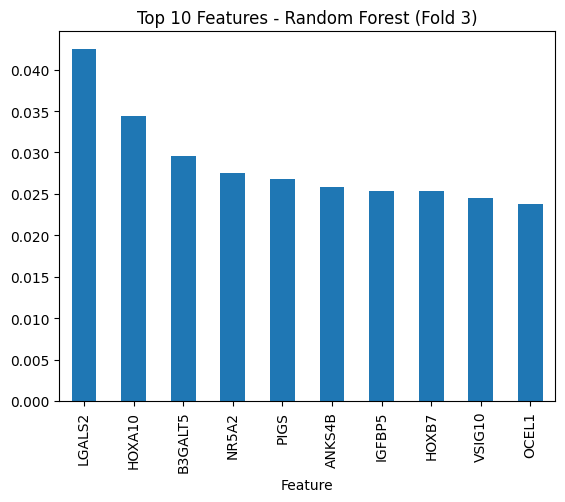

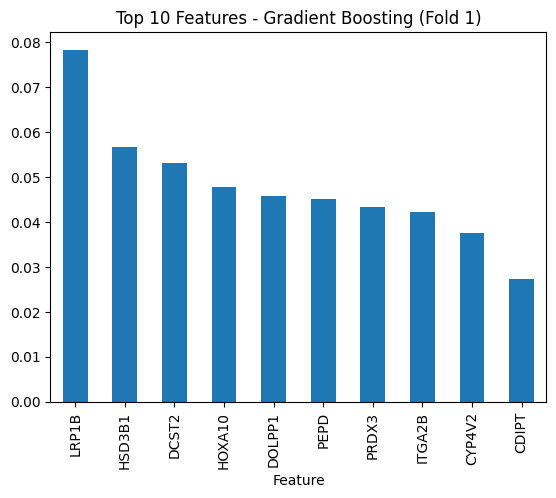

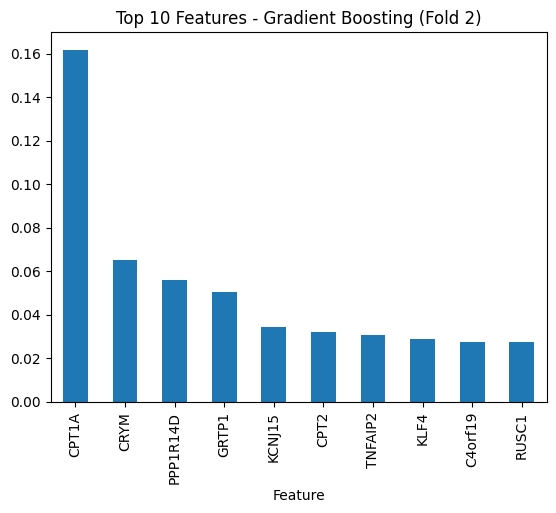

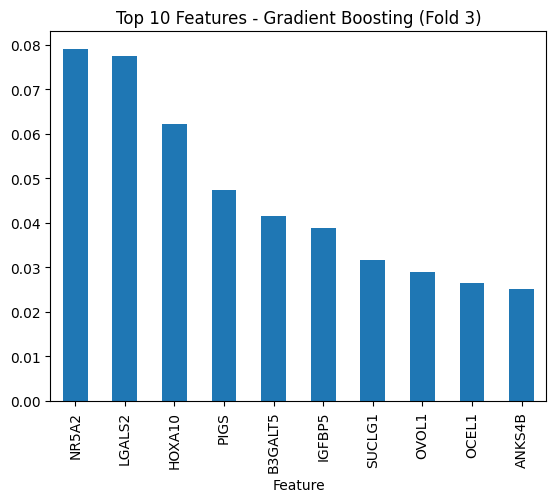

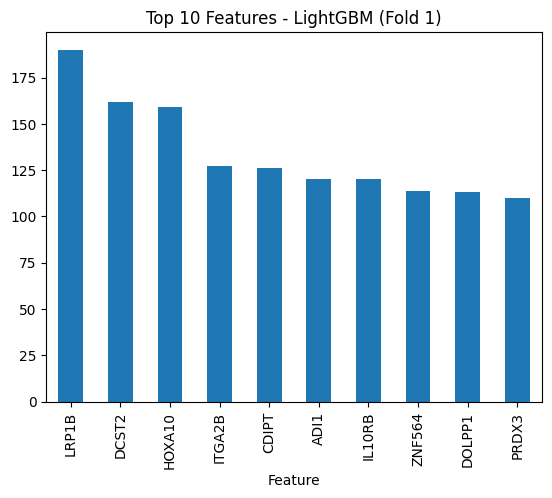

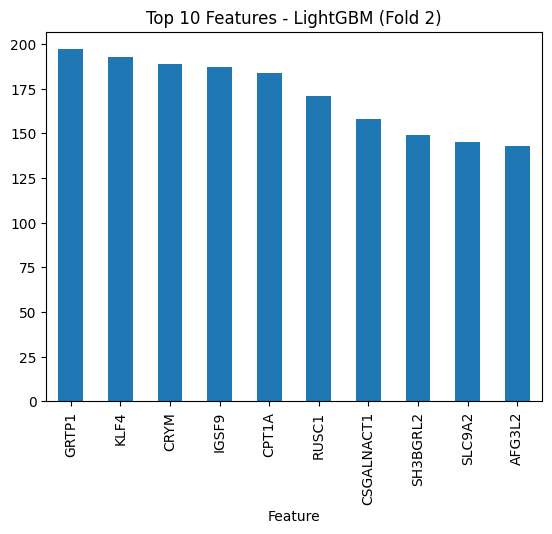

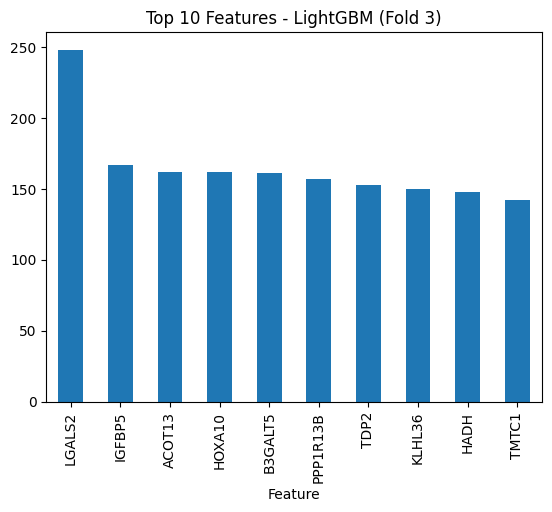

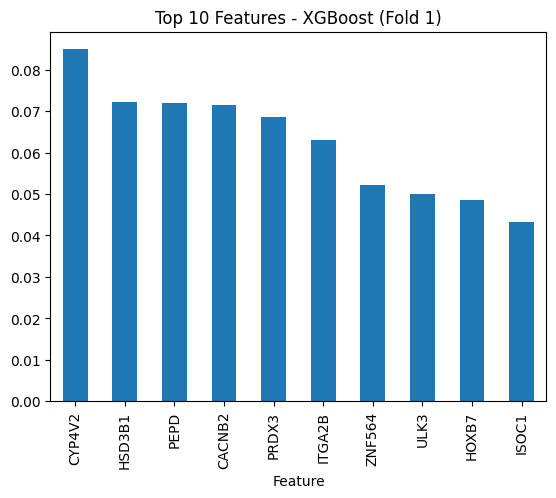

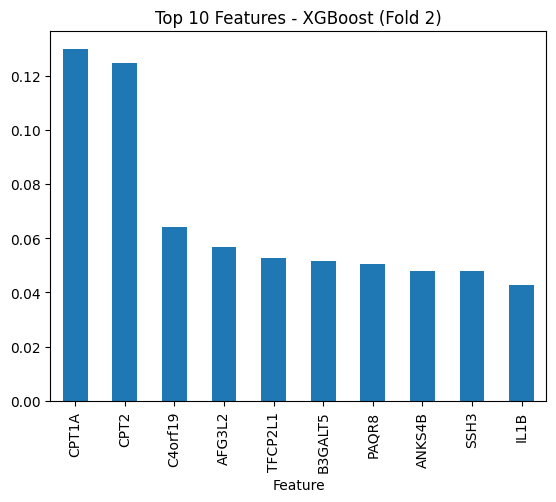

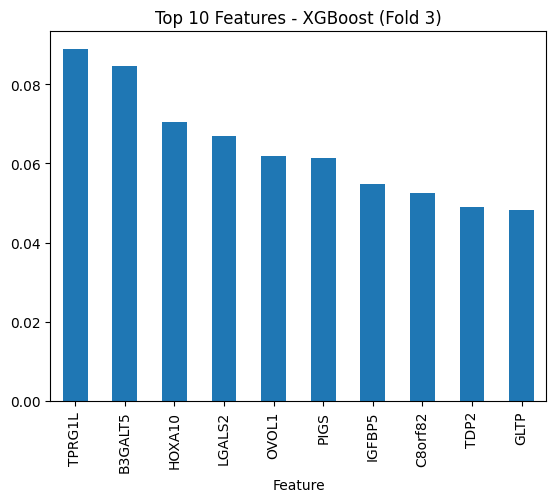

In [69]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Przygotowanie Danych ===
X = pd.DataFrame(adata.X, index=ustekinumab.index, columns=numerical_data.columns)
y = ustekinumab['response']
groups = ustekinumab['dataset']

# Zakodowanie etykiet
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("‚úÖ Dane zosta≈Çy przygotowane.")
print(f"üéØ Unikalne warto≈õci w y: {np.unique(y)}\n")

# === 2. GroupKFold - Podzia≈Ç na foldy walidacyjne ===
print("üöÄ Walidacja krzy≈ºowa z u≈ºyciem GroupKFold na pe≈Çnym zbiorze danych...")

group_kfold = GroupKFold(n_splits=3)
fold_indices = []

for fold_idx, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups)):
    train_groups = groups.iloc[train_idx].unique()
    val_groups = groups.iloc[val_idx].unique()

    fold_indices.append((train_idx, val_idx))
    print(f"üîÑ **Fold {fold_idx + 1}**")
    print(f"Train Groups: {train_groups}")
    print(f"Validation Groups: {val_groups}")
    print("-" * 40)

input("‚úÖ Sprawd≈∫ powy≈ºszy podzia≈Ç grup i wci≈õnij Enter, aby kontynuowaƒá...")

# === 3. Definicja modeli i hiperparametr√≥w ===
models = {
    'Random Forest': {
        'classifier': RandomForestClassifier(random_state=23),
        'param_grid': {
            'feature_selection__k': [20, 50],
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [5, 10, None],
        }
    },
    'Gradient Boosting': {
        'classifier': GradientBoostingClassifier(random_state=23),
        'param_grid': {
            'feature_selection__k': [50],
            'classifier__n_estimators': [100, 150],
            'classifier__learning_rate': [0.05, 0.1],
        }
    },
    'LightGBM': {
        'classifier': LGBMClassifier(random_state=23),
        'param_grid': {
            'feature_selection__k': [20, 50],
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [-1, 10, 20],
        }
    },
    'XGBoost': {
        'classifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=23),
        'param_grid': {
            'feature_selection__k': [20, 50],
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [3, 5, 7],
        }
    },
    'Logistic Regression': {
        'classifier': LogisticRegression(max_iter=1000, random_state=23),
        'param_grid': {
            'feature_selection__k': [20, 50],
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear', 'lbfgs']
        }
    }
}

# === 4. Trenowanie modeli i zbieranie wynik√≥w ===
roc_data = []
confusion_matrices = []
feature_importances_all = []

for model_name, model_info in models.items():
    param_grid = model_info['param_grid']

    for fold_idx, (train_idx, val_idx) in enumerate(fold_indices):
        print(f"üîÑ **Fold {fold_idx + 1} - {model_name}**")

        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        smote = SMOTE(sampling_strategy='minority', random_state=23)
        X_train_res, y_train_res = smote.fit_resample(X_train_fold, y_train_fold)

        pipeline = ImbPipeline([
            ('variance', VarianceThreshold(threshold=0.01)),
            ('scaling', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
            ('classifier', model_info['classifier'])
        ])

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=3,
            scoring='roc_auc',
            n_jobs=-1
        )

        grid_search.fit(X_train_res, y_train_res)
        best_model = grid_search.best_estimator_

        # ROC-AUC
        y_prob = best_model.predict_proba(X_val_fold)[:, 1]
        roc_auc = roc_auc_score(y_val_fold, y_prob)
        fpr, tpr, _ = roc_curve(y_val_fold, y_prob)
        roc_data.append((model_name, fold_idx + 1, fpr, tpr, roc_auc))

        # Macierz b≈Çƒôdu
        y_pred = best_model.predict(X_val_fold)
        cm = confusion_matrix(y_val_fold, y_pred)
        confusion_matrices.append((model_name, fold_idx + 1, cm))

        # Wa≈ºno≈õƒá cech (je≈õli dostƒôpna)
        if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
            importances = best_model.named_steps['classifier'].feature_importances_
            selected_features = X_train_res.columns[best_model.named_steps['feature_selection'].get_support()]
            feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
            top10 = feature_importance_df.nlargest(10, 'Importance')
            feature_importances_all.append((model_name, fold_idx + 1, top10))

# === 5. Wizualizacja ===

# Krzywe ROC
plt.figure(figsize=(14, 10))
for model_name, fold_idx, fpr, tpr, auc in roc_data:
    plt.plot(fpr, tpr, label=f'{model_name} (Fold {fold_idx}) AUC={auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curves with Fold Numbers')
plt.legend()
plt.show()

# Macierze b≈Çƒôdu
for model_name, fold_idx, cm in confusion_matrices:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} (Fold {fold_idx})')
    plt.show()

# Najwa≈ºniejsze cechy
for model_name, fold_idx, top10 in feature_importances_all:
    top10.plot(kind='bar', x='Feature', y='Importance', legend=False)
    plt.title(f'Top 10 Features - {model_name} (Fold {fold_idx})')
    plt.show()


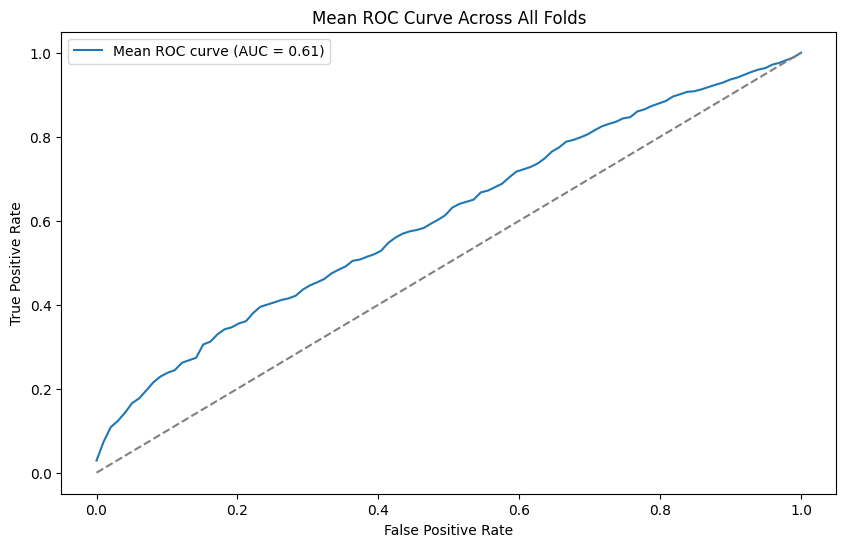

In [71]:
# ≈örednia krzywa ROC dla wszystkich fold√≥w
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

for _, _, fpr, tpr, _ in roc_data:
    mean_tpr += np.interp(mean_fpr, fpr, tpr)

mean_tpr /= len(roc_data)
mean_auc = np.mean([auc for _, _, _, _, auc in roc_data])

plt.figure(figsize=(10, 6))
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC curve (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve Across All Folds')
plt.legend()
plt.show()

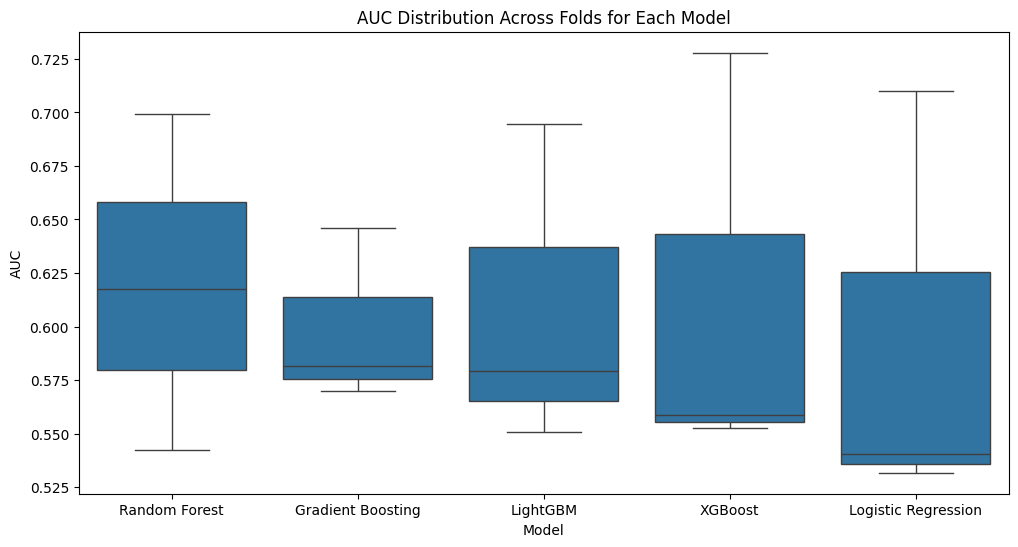

In [72]:
import seaborn as sns

# Analiza rozrzutu AUC dla ka≈ºdego modelu
auc_df = pd.DataFrame(roc_data, columns=['Model', 'Fold', 'FPR', 'TPR', 'AUC'])

plt.figure(figsize=(12, 6))
sns.boxplot(data=auc_df, x='Model', y='AUC')
plt.title('AUC Distribution Across Folds for Each Model')
plt.show()


In [74]:
import numpy as np
import pandas as pd

# Odtworzenie validation_results na podstawie dostƒôpnych danych
validation_results = []

for model_name in set(m[0] for m in roc_data):
    model_roc_aucs = [auc for m_name, _, _, _, auc in roc_data if m_name == model_name]
    model_confusions = [cm for m_name, _, cm in confusion_matrices if m_name == model_name]

    # ≈örednia AUC
    mean_auc = np.mean(model_roc_aucs)

    # ≈ÅƒÖczna macierz b≈Çƒôdu
    total_cm = np.sum(model_confusions, axis=0)
    TN, FP, FN, TP = total_cm.ravel()

    # Dodatkowe metryki
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    validation_results.append({
        'Model': model_name,
        'Mean AUC': mean_auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Total Confusion Matrix': total_cm
    })

# Wy≈õwietlenie wynik√≥w jako tabela
validation_summary = pd.DataFrame(validation_results)
print(validation_summary)


                 Model  Mean AUC  Accuracy  Precision    Recall  F1 Score  \
0  Logistic Regression  0.594055  0.540984   0.301282  0.486207  0.372032   
1             LightGBM  0.608233  0.648023   0.328767  0.248276  0.282908   
2    Gradient Boosting  0.599137  0.636451   0.341818  0.324138  0.332743   
3              XGBoost  0.612903  0.652845   0.381757  0.389655  0.385666   
4        Random Forest  0.619560  0.663452   0.304636  0.158621  0.208617   

     Total Confusion Matrix  
0  [[420, 327], [149, 141]]  
1   [[600, 147], [218, 72]]  
2   [[566, 181], [196, 94]]  
3  [[564, 183], [177, 113]]  
4   [[642, 105], [244, 46]]  


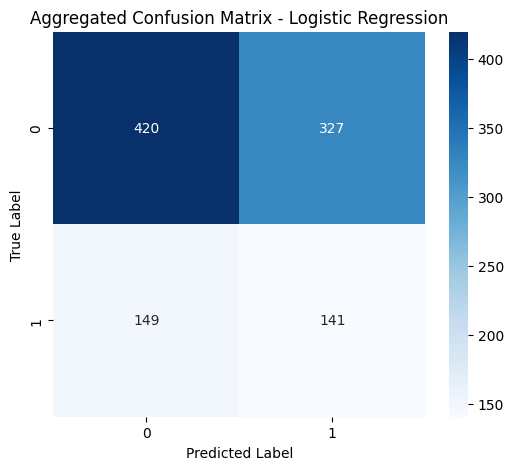

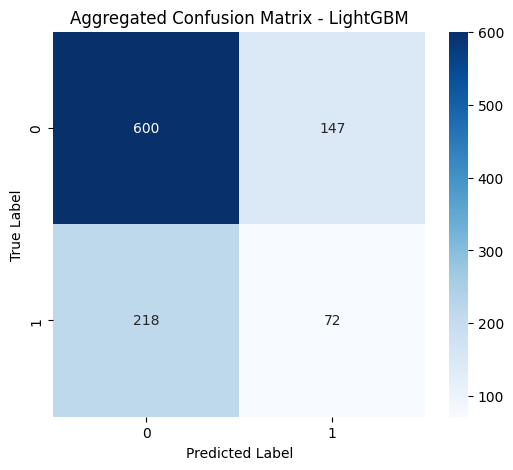

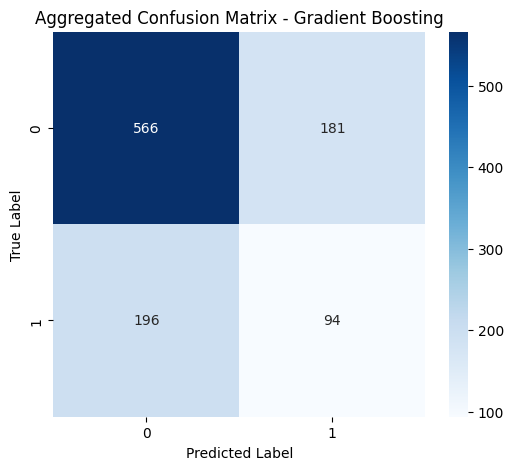

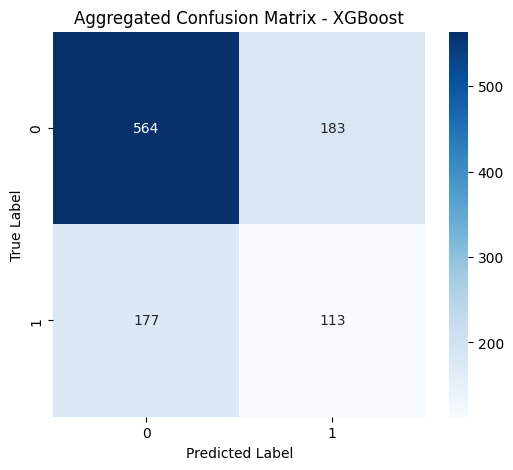

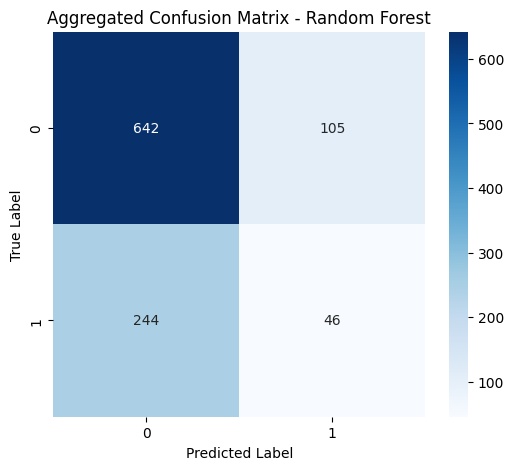

In [75]:
for result in validation_results:
    model_name = result['Model']
    cm = result['Total Confusion Matrix']

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues'
    )
    plt.title(f'Aggregated Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
